In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from wand.image import Image
from wand.color import Color
import webbrowser

In [2]:
def slidingNormalize(vs, wl):
    window = np.arange(0,wl)
    l = np.min(vs[window])
    h = np.max(vs[window])
    while l == h and wl < int(len(vs)):
        wl = wl + 2
        window = np.arange(0,wl)
        l = np.min(vs[window])
        h = np.max(vs[window])
    if l == h:
        for v in vs:
            yield v
    else:
        print("wl = ", wl)
        half = int(wl/2)
        for i in range(0,half):
            yield (vs[i] - l) / (h - l)
        for i in range(0,len(vs)-wl):
            window = window + 1
            l = np.min(vs[window])
            h = np.max(vs[window])
            yield (vs[i+half] - l) / (h - l)
        for i in range(0,half):
            yield (vs[i+len(vs)-half] - l) / (h - l)

def cropTo(img, xl,xh, yl,yh):
    return img[yl:yh, xl:xh]

def extractLine(img, y, adaptiveNormalize):
    w = img.shape[1]
    h = img.shape[0]
    xs = np.arange(w)
    if not adaptiveNormalize:
        ys = img[y,xs, 1]
        ys = ys - np.min(ys)
        ys = ys / np.max(ys)
    else:
        wl = int(w/10)
        print(wl)
        ys = img[y,xs, 1]
        ys = np.array(list(slidingNormalize(ys, wl)))
    return xs,ys

In [3]:
def crossings(t, ys):
    x = 0
    y0 = ys[0]
    h = y0 > t
    for y in ys:
        b = y > t
        if not (b == h): # transition
            # 1 --o
            #      \xi
            # t     \
            #        \
            # 0       o-----
            #     x   x+1
            xi = (t - y0) / (y - y0)
            h = b
            yield x - 1 + xi
        x = x + 1
        y0 = y
    #yield x

def widths(cs):
    first = True
    for x in cs:
        if first:
            first = False
        else:
            yield x - x0
        x0 = x
        
def barsToImg(bars):
    quiet = [1,1,1,1,1,1,1,1,1]
    bs = quiet + list(bars) + quiet
    return np.transpose(np.reshape(np.array(np.repeat(bs,20)), (len(bs), 20)))

In [4]:
def widthsToBlocks(ws):
    cal = np.array([ws[0],ws[1],ws[2],ws[-1],ws[-2],ws[-3]])
    l = np.average(cal)
    print(l)
    total = sum(np.round(ws/l).astype(int))
    while not (total == 95) and sum(np.round(cal/l).astype(int)) == 6:
        if total < 95:
            l = l - 0.01
        else:
            l = l + 0.01
        total = sum(np.round(ws/l).astype(int))
    return zip(np.round(ws/l).astype(int), np.tile([0,1],int(len(ws)/2)+1))
    #l = np.average([ws[0],ws[1],ws[2],ws[-1],ws[-2],ws[-3]])
    #return zip(np.round(ws/l).astype(int), np.tile([0,1],int(len(ws)/2)+1))

def blocksToBars(bs):
    for (n,c) in bs:
        for i in range(0,n):
            yield c
            
def splitBy(ss, vs):
    return zip(vs, blocksToBars(zip(ss, range(0,len(ss)))))

def readEAN(ws):
    bars = blocksToBars(widthsToBlocks(ws))
    ss = splitBy([3, 6*7, 5, 6*7, 3], bars)
    return list(ss)


digitsL = { "[1 1 1 0 0 1 0]": 0,
            "[1 1 0 0 1 1 0]": 1,
            "[1 1 0 1 1 0 0]": 2,
            "[1 0 0 0 0 1 0]": 3,
            "[1 0 1 1 1 0 0]": 4,
            "[1 0 0 1 1 1 0]": 5,
            "[1 0 1 0 0 0 0]": 6,
            "[1 0 0 0 1 0 0]": 7,
            "[1 0 0 1 0 0 0]": 8,
            "[1 1 1 0 1 0 0]": 9
          }
digitsG = { "[1 0 1 1 0 0 0]": 0, 
            "[1 0 0 1 1 0 0]": 1, 
            "[1 1 0 0 1 0 0]": 2, 
            "[1 0 1 1 1 1 0]": 3, 
            "[1 1 0 0 0 1 0]": 4, 
            "[1 0 0 0 1 1 0]": 5, 
            "[1 1 1 1 0 1 0]": 6, 
            "[1 1 0 1 1 1 0]": 7, 
            "[1 1 0 1 0 0 0]": 8, 
            "[1 1 0 1 0 0 0]": 9
          }

digits0 = { "LLLLLL": 0,
            "LLGLGG": 1,
            "LLGGLG": 2,
            "LLGGGL": 3,
            "LGLLGG": 4,
            "LGGLLG": 5,
            "LGGGLL": 6,
            "LGLGLG": 7,
            "LGLGGL": 8,
            "LGGLGL": 9    
          }

def digitEAN(bars):
    s = str(bars)
    if s in digitsL:
        return ('L', digitsL[s])
    elif s in digitsG:
        return ('G', digitsG[s])
    return ('X', "X -- " + s)

def checksumEAN13(n):
    if not all(isinstance(x, int) for x in n) or not (len(n) == 13):
        return False
    d = 10 - int(np.dot(n[0:12], np.tile([1,3], 6))) % 10
    return d == n[12]

def widthsToEAN13(ws):
    zones = readEAN(ws)
    # print(zones)
    ls = np.reshape(np.array(list(map(lambda v: v[0], filter(lambda v: v[1] == 1, zones)))), (6,7))
    rs = np.reshape(np.array(list(map(lambda v: 1 - v[0], filter(lambda v: v[1] == 3, zones)))), (6,7))
    #print(ls)
    #print(rs)
    s = ""
    n = []
    for i in range(0,6):
        (c,d) = digitEAN(ls[i])
        s = s + c
        n = n + [d]
        #print(c, d)
    for i in range(0,6):
        (c,d) = digitEAN(rs[i])
        n = n + [d]
        #print(c, d)
    if s in digits0:
        n = [digits0[s]] + n
        #print(n)
    #else:
        #print(s, n)
    return (checksumEAN13(n), n)

def decodeEAN13(img, y, t, adaptiveNormalize):
    xs,ys = extractLine(img, y, adaptiveNormalize)
    cs = np.array(list(crossings(t, ys)))
    ws = np.array(list(widths(cs)))
    plt.figure(figsize=(15,1))
    plt.plot(xs,ys,'-')
    plt.plot(cs, np.full(len(cs), t), '.')
    plt.show()
    
    (valid, code) = widthsToEAN13(ws)
    if valid:
        plt.imshow(img)
        print(code)
        return (valid, code)
    # helpful debugging information
    print(list(ws))
    l = np.average([ws[0],ws[1],ws[2],ws[-1],ws[-2],ws[-3]])
    print(list(np.round(ws/l).astype(int)))
    plt.imshow(barsToImg(blocksToBars(widthsToBlocks(ws))))
    return (valid, code)

In [5]:
# Some code to remove transparency from examples from wikipeida
#with Image(filename='200px-Example_barcode.svg.png') as wimg:
#with Image(filename='500px-Wikipedia_barcode_128.svg.png') as wimg:
with Image(filename='500px-EAN-13-5901234123457.svg.png') as wimg:
#with Image(filename='500px-UPC-A-036000291452.svg.png') as wimg:
    with Color('#fff') as white:
        with Image(width=wimg.width, height=wimg.height, background=white) as back:
            back.save(filename='back.png')
            back.composite(wimg,0,0)
            back.save(filename='test5.png')

50
wl =  68


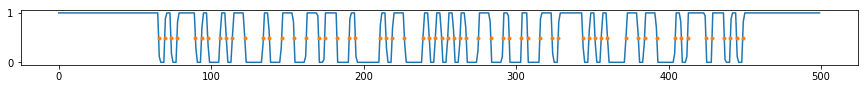

4.019394839765371
[5, 9, 0, 1, 2, 3, 4, 1, 2, 3, 4, 5, 7]


(True, [5, 9, 0, 1, 2, 3, 4, 1, 2, 3, 4, 5, 7])

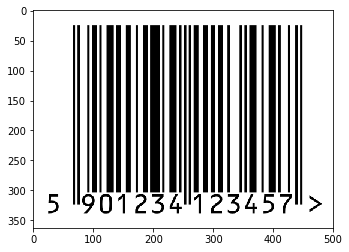

In [6]:
decodeEAN13(cv2.imread('test5.png'), 40, 0.5, True)

(Text(0.5,1,'The image that we are working with'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

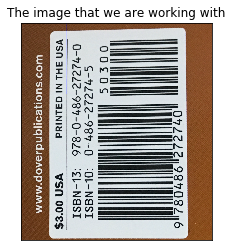

In [7]:
#Using one of Ryan Ozellos barcode image as an example to show how to:
#Convert to greyscale, Edge Detection(canny & mask), and crop the bar code out of the image
img = (cv2.imread('C:/Users/chris/Image_Data/barcode-images/Ryan/IMG_E1991.JPG'))
plt.imshow(img)
plt.title('The image that we are working with'), plt.xticks([]), plt.yticks([])
#decodeEAN13(img, 300, 0.4, True)

Text(0.5,1,'Image coverted to grayscale')

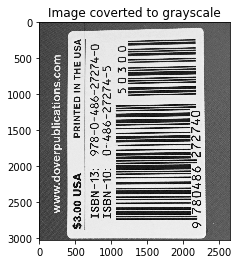

In [8]:
#Converting image to grayscale
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(gray_img,cmap='gray')
plt.title('Image coverted to grayscale')

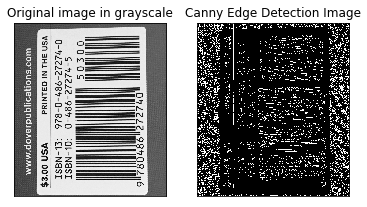

In [9]:
#Canny edge detection
edges = cv2.Canny(gray_img,10,30)

plt.subplot(121),plt.imshow(gray_img,cmap = 'gray')
plt.title('Original image in grayscale'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Canny Edge Detection Image'), plt.xticks([]), plt.yticks([])

plt.show()

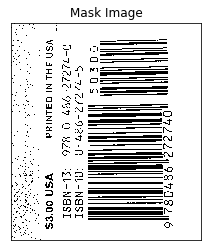

In [10]:
#Mask edge detection
lower_bound = np.array([60])
upper_bound = np.array([255])
mask = cv2.inRange(gray_img, lower_bound, upper_bound)
plt.title('Mask Image'), plt.xticks([]), plt.yticks([])

plt.imshow(mask, cmap='gray')

True

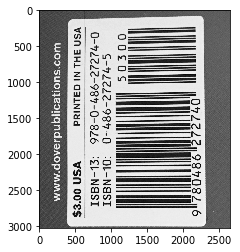

In [11]:
img2 = plt.imshow(gray_img,cmap='gray')
gray_img2 = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
edges = cv2.Canny(gray_img,10,250,apertureSize = 3)
lines = cv2.HoughLines(image=edges, rho=2, theta=np.pi/180,threshold=300)

for i in range(0, lines.shape[0]):
    rho,theta = lines[i,0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 10000*(-b))
    y1 = int(y0 + 10000*(a))
    x2 = int(x0 - 10000*(-b))
    y2 = int(y0 - 10000*(a))

    cv2.line(img,(x1,y1),(x2,y2),(255,0,0),2)

cv2.imwrite('houghlines3.jpg',img)

In [12]:
webbrowser.open('houghlines3.jpg')

True

In [13]:
#binary lines edges
def find_edges_2D(img_array):
    kernel = np.array([100, 0, -100])
    edges = np.zeros(len(img_array), dtype = np.float64)
    for i in range(0, len(img_array)-1):
        if(i == 0):
            #assume same outside of image at edges of array
            if(img_array[i] == 1):
                edges[i] = (kernel[0] * 1) + (kernel[1] * img_array[i]) + (kernel[2] * img_array[i + 1])
            elif(img_array[i] == 0):
                edges[i] = (kernel[0] * 0) + (kernel[1] * img_array[i]) + (kernel[2] * img_array[i + 1])
        elif(i == (len(img_array - 1))):
            if(img_array[i] == 1):
                edges[i] = (kernel[0] * img_array[i - 1]) + (kernel[1] * img_array[i]) + (kernel[2] * 1)
            elif(img_array[i] == 0):
                edges[i] = (kernel[0] * img_array[i - 1]) + (kernel[1] * img_array[i]) + (kernel[2] * 0)
        else:
            edges[i] = (kernel[0] * img_array[i - 1]) + (kernel[1] * img_array[i]) + (kernel[2] * img_array[i + 1])
    return edges

In [14]:
def crop(img_file, xory):
    #convert image to edge detected image using canny and find the 
    #lines in the images and then plot them over the original image
    img = cv2.imread(img_file)
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_og = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    edges = cv2.Canny(gray_img, 50, 150, apertureSize = 3)
    lines = cv2.HoughLines(image=edges, rho=2, theta=np.pi/180, threshold=300)

    for i in  range(0,lines.shape[0]):
        rho,theta = lines[i,0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 10000*(-b))
        y1 = int(y0 + 10000*(a))
        x2 = int(x0 - 10000*(-b))
        y2 = int(y0 - 10000*(a))
        cv2.line(img,(x1,y1),(x2,y2),(255,0,0),2)
    
    #make a binary array for the presence of pure red by transversing the x values at the very top of the image
    #bl = binary lines
    if(xory == 'x'):
        bl = np.zeros(len(img[0,:,:]), dtype=int)
        for i in range(0, len(img[0,:,:])):
            if (img[0, i, 0] == 255 and img[0, i, 1] == 0 and img[0, i, 2] == 0):
                bl[i] = 1
    elif(xory == 'y'):
        bl = np.zeros(len(img[:,0,:]), dtype=int)
        for i in range(0, len(img[:,0,:])):
            if (img[i, 0, 0] == 255 and img[i, 0, 1] == 0 and img[i, 0, 2] == 0):
                bl[i] = 1

    kernel = np.array([100, 0, -100])
    edges = np.zeros(len(bl), dtype = np.float64)
    for i in range(0, len(bl)-1):
        if(i == 0):
            #assume same outside of image at edges of array
            if(bl[i] == 1):
                edges[i] = (kernel[0] * 1) + (kernel[1] * bl[i]) + (kernel[2] * bl[i + 1])
            elif(bl[i] == 0):
                edges[i] = (kernel[0] * 0) + (kernel[1] * bl[i]) + (kernel[2] * bl[i + 1])
        elif(i == (len(bl - 1))):
            if(bl[i] == 1):
                edges[i] = (kernel[0] * bl[i - 1]) + (kernel[1] * bl[i]) + (kernel[2] * 1)
            elif(bl[i] == 0):
                edges[i] = (kernel[0] * bl[i - 1]) + (kernel[1] * bl[i]) + (kernel[2] * 0)
        else:
            edges[i] = (kernel[0] * bl[i - 1]) + (kernel[1] * bl[i]) + (kernel[2] * bl[i + 1])
    
    #find longest span without any lines
    start_ind = []
    end_ind = []
    test_val = 0
    for i in range(0, len(edges)):
        test_val = edges[i]
        if(test_val != 0):
            if(test_val == -100):
                start_ind.append(0)            
            break
            
    # -2 to avoid going out of range with following i+1
    for i in range(0, len(edges) - 1):
        #print(i)
        if(edges[i] == 100 and edges[i + 1] == 0):
            start_ind.append(i) 
            #print("s", start_ind)
        if(edges[i] == 0 and edges[i + 1] == -100):
            end_ind.append(i + 1)
            #print("e", end_ind)
    for i in range(len(edges) - 1, -1, -1):
        test_val = edges[i]
        if(test_val != 0):
            if(test_val == 100):
                end_ind.append(len(edges) - 1)            
            break
    #print(edges[4000:])
    start_ind = np.array(start_ind)
    end_ind = np.array(end_ind)
    range_zeros = []
    for i in range(0, len(start_ind)):
        range_zeros.append([start_ind[i],end_ind[i]])
    
    deltas = []
    for i in range_zeros:
        deltas.append(i[1] - i[0])
    deltas = np.array(deltas)

    crop = range_zeros[np.where(deltas == max(deltas))[0][0]]
    print(crop[0],crop[1])
    if(xory == 'x'):
        img_og = img_og[:,crop[0]:crop[1]]
    elif(xory == 'y'):
        img_og = img_og[crop[0]:crop[1], :]

    fig = plt.figure(figsize=(8,8))
    c = 2
    r = 1
    fig.add_subplot(1,2,1)
    plt.imshow(img)
    fig.add_subplot(1,2,2)
    plt.imshow(img_og)
    plt.show()
    
    return(img_og)

1437 2277


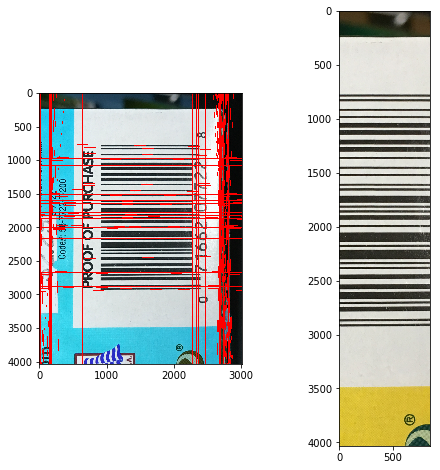

array([[[ 67,  51,  25],
        [ 67,  51,  25],
        [ 67,  51,  25],
        ...,
        [ 23,  22,  17],
        [ 23,  22,  17],
        [ 24,  23,  18]],

       [[ 68,  52,  26],
        [ 67,  51,  25],
        [ 67,  51,  25],
        ...,
        [ 23,  22,  17],
        [ 23,  22,  17],
        [ 24,  23,  18]],

       [[ 68,  52,  26],
        [ 68,  52,  26],
        [ 67,  51,  25],
        ...,
        [ 23,  22,  17],
        [ 23,  22,  17],
        [ 23,  22,  17]],

       ...,

       [[207, 181, 107],
        [224, 200, 114],
        [224, 201, 107],
        ...,
        [ 36,  63,  32],
        [ 56,  83,  50],
        [ 78, 104,  67]],

       [[208, 182, 108],
        [224, 200, 114],
        [223, 200, 106],
        ...,
        [ 16,  43,  12],
        [ 25,  52,  19],
        [ 51,  77,  42]],

       [[208, 182, 108],
        [223, 199, 113],
        [221, 198, 104],
        ...,
        [ 13,  42,  11],
        [ 20,  47,  14],
        [ 49,  75,  40]]

In [15]:
#Example 1: Ryans Ozellos Image
crop('C:/Users/chris/Image_Data/barcode-images/Ryan/IMG_2001.jpg', 'x')
#

1963 2063


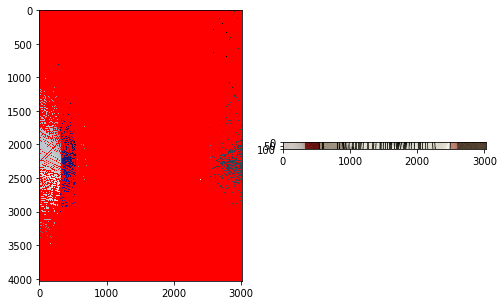

array([[[206, 195, 191],
        [203, 192, 188],
        [201, 190, 186],
        ...,
        [ 68,  55,  38],
        [ 65,  52,  35],
        [ 64,  51,  34]],

       [[205, 194, 190],
        [204, 193, 189],
        [204, 193, 189],
        ...,
        [ 66,  53,  36],
        [ 64,  51,  34],
        [ 64,  51,  34]],

       [[204, 193, 189],
        [205, 194, 190],
        [206, 195, 191],
        ...,
        [ 67,  54,  37],
        [ 65,  52,  35],
        [ 66,  53,  36]],

       ...,

       [[212, 201, 197],
        [210, 199, 195],
        [209, 198, 194],
        ...,
        [ 76,  61,  42],
        [ 77,  62,  43],
        [ 79,  64,  45]],

       [[213, 202, 198],
        [211, 200, 196],
        [209, 198, 194],
        ...,
        [ 79,  64,  45],
        [ 77,  62,  43],
        [ 77,  62,  43]],

       [[211, 200, 196],
        [210, 199, 195],
        [208, 197, 193],
        ...,
        [ 82,  67,  48],
        [ 80,  65,  46],
        [ 79,  64,  45]]

In [16]:
#Example 2: My image - chip bag
crop('C:/Users/chris/Image_Data/barcode-images/Christian/IMAGE#3.jpg', 'y')
#This example worked surprisingly well!

185 639


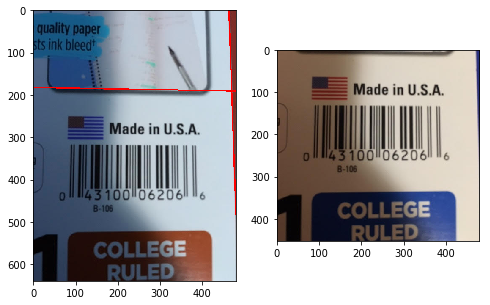

array([[[128,  96,  75],
        [128,  96,  75],
        [128,  96,  75],
        ...,
        [ 41,  48, 126],
        [ 40,  48, 123],
        [ 39,  49, 121]],

       [[128,  96,  75],
        [128,  96,  75],
        [128,  96,  75],
        ...,
        [ 41,  48, 126],
        [ 40,  48, 123],
        [ 39,  49, 121]],

       [[127,  95,  74],
        [127,  95,  74],
        [127,  95,  74],
        ...,
        [ 41,  48, 126],
        [ 40,  48, 123],
        [ 39,  49, 121]],

       ...,

       [[ 83,  55,  41],
        [ 83,  55,  41],
        [ 83,  55,  41],
        ...,
        [232, 220, 204],
        [220, 208, 192],
        [207, 195, 179]],

       [[ 82,  54,  40],
        [ 82,  54,  40],
        [ 82,  54,  40],
        ...,
        [232, 220, 204],
        [220, 208, 192],
        [207, 195, 179]],

       [[ 82,  54,  40],
        [ 82,  54,  40],
        [ 82,  54,  40],
        ...,
        [232, 220, 204],
        [220, 208, 192],
        [207, 195, 179]]

In [17]:
#Example 3: My image - book
crop('C:/Users/chris/Image_Data/barcode-images/Christian/IMAGE#10.jpg', 'y')
#This image does not work as well as the two above. 
#Although it does keep the part with the barcode

3329 3346


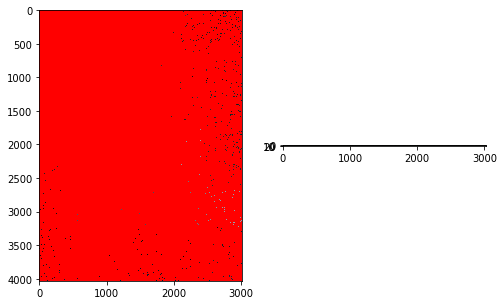

array([[[18, 19, 11],
        [19, 20, 12],
        [22, 23, 15],
        ...,
        [27, 28, 20],
        [27, 28, 20],
        [28, 29, 21]],

       [[16, 17,  9],
        [21, 22, 14],
        [27, 28, 20],
        ...,
        [27, 28, 20],
        [26, 27, 19],
        [27, 28, 20]],

       [[16, 17,  9],
        [20, 21, 13],
        [24, 25, 17],
        ...,
        [28, 29, 21],
        [25, 26, 18],
        [24, 25, 17]],

       ...,

       [[18, 19, 11],
        [17, 18, 10],
        [15, 16,  8],
        ...,
        [27, 30, 21],
        [31, 34, 25],
        [34, 37, 28]],

       [[18, 19, 11],
        [14, 15,  7],
        [13, 14,  6],
        ...,
        [33, 37, 23],
        [36, 40, 26],
        [34, 38, 24]],

       [[25, 26, 18],
        [21, 22, 14],
        [18, 19, 11],
        ...,
        [38, 42, 28],
        [39, 43, 29],
        [37, 41, 27]]], dtype=uint8)

In [19]:
#Example 4: My image - Shoe box
crop('C:/Users/chris/Image_Data/barcode-images/Christian/IMAGE#6.jpg', 'y')
#Draws too many lines. Even though the farthest line is cropped it is still
#unreadable because there are way too many lines drawn so the new cropped image is too small

1383 4031


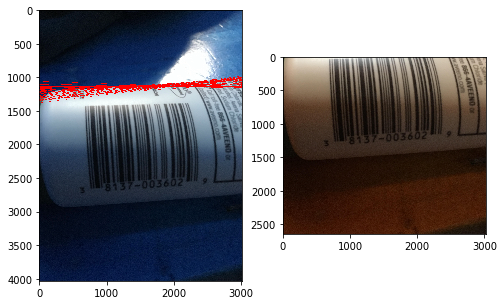

array([[[102, 115,  87],
        [ 99, 112,  84],
        [ 96, 109,  81],
        ...,
        [173, 156, 136],
        [173, 156, 136],
        [174, 157, 137]],

       [[ 98, 108,  81],
        [ 97, 107,  80],
        [ 96, 106,  79],
        ...,
        [170, 152, 132],
        [172, 154, 134],
        [175, 157, 137]],

       [[ 99, 109,  82],
        [ 98, 108,  81],
        [ 98, 108,  81],
        ...,
        [165, 147, 127],
        [168, 150, 130],
        [170, 152, 132]],

       ...,

       [[ 71,  28,   9],
        [ 69,  26,   7],
        [ 71,  28,   9],
        ...,
        [ 26,  17,  12],
        [ 23,  14,   9],
        [ 21,  12,   7]],

       [[ 71,  28,   9],
        [ 70,  27,   8],
        [ 73,  30,  11],
        ...,
        [ 23,  14,   9],
        [ 21,  12,   7],
        [ 23,  14,   9]],

       [[ 78,  35,  16],
        [ 75,  32,  13],
        [ 74,  31,  12],
        ...,
        [ 21,  12,   7],
        [ 20,  11,   6],
        [ 26,  17,  12]]

In [20]:
#Example 5: My image - Lotion bottle
crop('C:/Users/chris/Image_Data/barcode-images/Christian/IMAGE#7.jpg', 'y')
#The shadow is interfering so it does not draw any lines within the shadow

In [21]:
#Example 6: My image - book
crop('C:/Users/chris/Image_Data/barcode-images/Christian/IMAGE#1.jpg', 'y')
#The rest of my images give me this error "max() arg is an empty sequence"
#I think it is because no lines are drawn
#And becasuse no lines are drawn it can't find the longest range between two lines

ValueError: max() arg is an empty sequence